# Workshop Python Image Analysis
*Martijn Wehrens, September 2025*

**Estimated time:** XX mins presenting + YY mins exercises

## Chapter 5: A very basic introduction into machine learning

<font face='Times New Roman' color=red>This notebook will probably need to be run on Google colab or the like, as laptops might not have the right architecture to run this.</font>

In [14]:
import torch
from torch import nn

from torch.utils.data import Dataset

import numpy as np

import tifffile as tiff
import matplotlib.pyplot as plt

In [2]:
# This code defines a VERY simple model for 12x12 pixels

class VerySimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(12*12, 2)

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear(x)
        return logits

# now test the neural network
simpleNN = VerySimpleNN().to('mps')
test_data = torch.rand(1, 12, 12, device='mps')  # random 12x12 image
pred = simpleNN(test_data)
print(pred)

tensor([[-0.1407, -0.3204]], device='mps:0', grad_fn=<LinearBackward0>)


In [3]:
# Now acquire the weights
weights = simpleNN.linear.weight.detach().cpu().numpy()
bias    = simpleNN.linear.bias.detach().cpu().numpy()
# print(weights)
# 
test_data_np = test_data.cpu().numpy().flatten()
# print(test_data_np)
# And manually calculate the outcome
outcome = np.sum(test_data_np*weights[0]) + bias
print(outcome)

[-0.14070532  0.00448395]


In [26]:

# test_data_np.flatten()
# weights[0]

In [4]:
np.sum(test_data_np.flatten()*weights[0])

np.float32(-0.07321869)

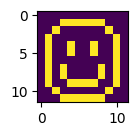

In [5]:
# Now define a data class, which actually only produces two pictures, 
# either a happy or sad emoji, together with annotation

# Two image paths
img_happy_path = '/Users/m.wehrens/Documents/git_repos/_UVA/2025_teaching_Py_image-analysis/Workshop_Py_image-analysis_2025/images/ML/smile.tif'
img_sad_path   = '/Users/m.wehrens/Documents/git_repos/_UVA/2025_teaching_Py_image-analysis/Workshop_Py_image-analysis_2025/images/ML/sad.tif'
img_sad2_path   = '/Users/m.wehrens/Documents/git_repos/_UVA/2025_teaching_Py_image-analysis/Workshop_Py_image-analysis_2025/images/ML/sad2.tif'

# Load images
img_happy = tiff.imread(img_happy_path)
img_sad   = tiff.imread(img_sad_path)
img_sad2  = tiff.imread(img_sad2_path)

# Show one image
fig, ax = plt.subplots(1,1, figsize=(3/2.54, 3/2.54))
_=ax.imshow(img_happy)

In [6]:
class Data_HappySad(Dataset):
    
    def __init__(self, targetdevice="mps",):
        
        self.targetdevice = targetdevice
        
        # Data and its labels, 0 = happy, 1 = sad
        self.data   = torch.tensor([img_happy, img_sad, img_sad2], 
                                   dtype=torch.float32)
        self.label  = torch.tensor([0        , 1,       1], 
                                   dtype=torch.long)
        
        # Normalize images
        self.data = self.data / 255.0
    
    def __len__(self):
        
        return len(self.data)
    
    def __getitem__(self, idx):
        
        return self.data[idx].to(self.targetdevice), self.label[idx].to(self.targetdevice)
        
        

In [54]:
my_data_happysad = Data_HappySad()
my_data_happysad_loader = torch.utils.data.DataLoader(my_data_happysad, 
                                                      batch_size=3, shuffle=False)

my_simple_model  = VerySimpleNN().to('mps')

In [38]:
my_data_happysad.__getitem__(0)

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.],
         [0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
         [0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.],
         [0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0.],
         [0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.]], device='mps:0'),
 tensor(0, device='mps:0'))

In [55]:
# now make a simple train loop
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_simple_model.parameters(), lr=.01)

# set model to training mode
my_simple_model.train()

gradient_list = [] # only for illustratory purposes
for epoch_idx in range(100):
    
    for b_idx, (X,y) in enumerate(my_data_happysad_loader): 
    
        pred = my_simple_model(X)
        loss = loss_fn(pred, y)
        
        loss.backward() # compute gradients
                
        # get the gradients as array (for illustratory purposes)
        gradients = my_simple_model.linear.weight.grad.detach().cpu().numpy()
        gradient_list.append(gradients)
        
        optimizer.step() # apply gradients
        optimizer.zero_grad() # reset gradients
    
        print('epoch =', epoch_idx, 'batch =',b_idx,', loss = ', loss.item())#, 'X.shape=', X.shape)
        

    
    

epoch = 0 batch = 0 , loss =  0.6953480243682861
epoch = 1 batch = 0 , loss =  0.5960262417793274
epoch = 2 batch = 0 , loss =  0.5735462307929993
epoch = 3 batch = 0 , loss =  0.537868320941925
epoch = 4 batch = 0 , loss =  0.4851878881454468
epoch = 5 batch = 0 , loss =  0.43704208731651306
epoch = 6 batch = 0 , loss =  0.40532758831977844
epoch = 7 batch = 0 , loss =  0.3844977915287018
epoch = 8 batch = 0 , loss =  0.36175569891929626
epoch = 9 batch = 0 , loss =  0.3333442509174347
epoch = 10 batch = 0 , loss =  0.30404040217399597
epoch = 11 batch = 0 , loss =  0.2791636288166046
epoch = 12 batch = 0 , loss =  0.2603031098842621
epoch = 13 batch = 0 , loss =  0.24544024467468262
epoch = 14 batch = 0 , loss =  0.23150841891765594
epoch = 15 batch = 0 , loss =  0.21680355072021484
epoch = 16 batch = 0 , loss =  0.2015841156244278
epoch = 17 batch = 0 , loss =  0.18716756999492645
epoch = 18 batch = 0 , loss =  0.17470116913318634
epoch = 19 batch = 0 , loss =  0.16444872319698334
e

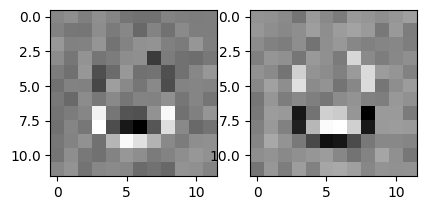

In [63]:
# now retrieve the weights
weights = my_simple_model.linear.weight.detach().cpu().numpy()

# visualize the weights
fig, axs = plt.subplots(1,2, figsize=(12/2.54, 6/2.54))
axs[0].imshow(weights[0].reshape(12,12), cmap='gray')
axs[1].imshow(weights[1].reshape(12,12), cmap='gray')


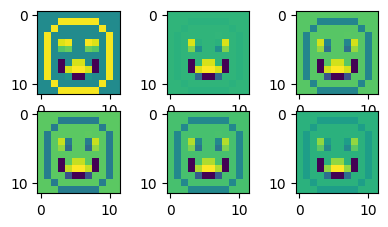

In [58]:
# show the first and second gradients
fig, axs = plt.subplots(2,3, figsize=(12/2.54, 6/2.54))
_=axs[0,0].imshow(gradient_list[0][0].reshape(12,12))
_=axs[0,1].imshow(gradient_list[1][0].reshape(12,12))
_=axs[0,2].imshow(gradient_list[2][0].reshape(12,12))
_=axs[1,0].imshow(gradient_list[3][0].reshape(12,12))
_=axs[1,1].imshow(gradient_list[4][0].reshape(12,12))
_=axs[1,2].imshow(gradient_list[5][0].reshape(12,12))

In [59]:
print(len(gradient_list))
gradient_list[0].shape
gradient_list[4][0].reshape((12,12)).shape

100


(12, 12)

In [60]:
# apply the model to image 1
X1 = my_data_happysad.__getitem__(0)[0].unsqueeze(0)
pred = my_simple_model(X1)
print('X1=', pred)
# and to image 2
X2 = my_data_happysad.__getitem__(1)[0].unsqueeze(0)
pred = my_simple_model(X2)
print('X12', pred)
# and to image 3
X3 = my_data_happysad.__getitem__(2)[0].unsqueeze(0)
pred = my_simple_model(X3)
print('X3=', pred)

X1= tensor([[ 2.0890, -1.5107]], device='mps:0', grad_fn=<LinearBackward0>)
X12 tensor([[-1.6538,  2.0169]], device='mps:0', grad_fn=<LinearBackward0>)
X3= tensor([[-2.6456,  3.4767]], device='mps:0', grad_fn=<LinearBackward0>)


In [61]:
# Doesn't seem to work ??
# from torchsummary import summary
# summary(my_simple_model, input_size=(12,12))

In [62]:
# There should be 12x12 + 1 + 12x12 + 1 = 290 model parameters
sum(p.numel() for p in my_simple_model.parameters() if p.requires_grad)

290